# PCA for Algorithmic Trading: Data-Driven Risk Factors

PCA is useful for algorithmic trading in several respects. These include the data-driven derivation of risk factors by applying PCA to asset returns, and the construction of uncorrelated portfolios based on the principal components of the correlation matrix of asset returns.

In [Chapter 07 - Linear Models](../../07_linear_models), we explored risk factor models used in quantitative finance to capture the main drivers of returns. These models explain differences in returns on assets based on their exposure to systematic risk factors and the rewards associated with these factors. 

In particular, we explored the Fama-French approach that specifies factors based on prior knowledge about the empirical behavior of average returns, treats these factors as observable, and then estimates risk model coefficients using linear regression. An alternative approach treats risk factors as latent variables and uses factor analytic techniques like PCA to simultaneously estimate the factors and how the drive returns from historical returns.

In this section, we will review how this method derives factors in a purely statistical or data-driven way with the advantage of not requiring ex-ante knowledge of the behavior of asset returns.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.ticker import FuncFormatter

In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

## Get returns for equities with highest market cap

We will use the Quandl stock price data and select the daily adjusted close prices the 500 stocks with the largest market capitalization and data for the 2010-2018 period. We then compute the daily returns as follows:

In [4]:
idx = pd.IndexSlice
with pd.HDFStore('../../data/assets.h5') as store:
    stocks = store['us_equities/stocks'].marketcap.nlargest(500)
    returns = (store['quandl/wiki/prices']
               .loc[idx['2010': '2018', stocks.index], 'adj_close']
               .unstack('ticker')
               .pct_change())

We obtain 351 stocks and returns for over 2,000 trading days:

In [5]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2072 entries, 2010-01-04 to 2018-03-27
Columns: 351 entries, A to CBRE
dtypes: float64(351)
memory usage: 5.6 MB


### Winsorize & standardize returns

PCA is sensitive to outliers so we winsorize the data at the 2.5% and 97.5% quantiles, respectively:

In [6]:
returns = returns.clip(lower=returns.quantile(q=.025),
                       upper=returns.quantile(q=.975),
                       axis=1)

### Impute missing values

PCA does not permit missing data, so we will remove stocks that do not have data for at least 95% of the time period, and in a second step remove trading days that do not have observations on at least 95% of the remaining stocks.

In [7]:
returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
returns = returns.dropna(thresh=int(returns.shape[1] * .95))
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2071 entries, 2010-01-05 to 2018-03-27
Columns: 315 entries, A to LYB
dtypes: float64(315)
memory usage: 5.0 MB


We are left with 315 equity return series covering a similar period.

We impute any remaining missing values using the average return for any given trading day:

In [8]:
daily_avg = returns.mean(1)
returns = returns.apply(lambda x: x.fillna(daily_avg))

## Fit PCA

Now we are ready to fit the principal components model to the asset returns using default parameters to compute all components using the full SVD algorithm:

In [9]:
cov = np.cov(returns, rowvar=False) 

In [10]:
pca = PCA(n_components='mle')
pca.fit(returns)

PCA(n_components='mle')

### Visualize Explained Variance

We find that the most important factor explains around 30% of the daily return variation. The dominant factor is usually interpreted as ‘the market’, whereas the remaining factors can be interpreted as industry or style factors in line with our discussion in chapters 5 and 7, depending on the results of closer inspection (see next example). 

The plot on the right shows the cumulative explained variance and indicates that around 10 factors explain 60% of the returns of this large cross-section of stocks.  

The cumulative plot shows a typical 'elbow' pattern that can help identify a suitable target dimensionality because it indicates that additional components add less explanatory value.

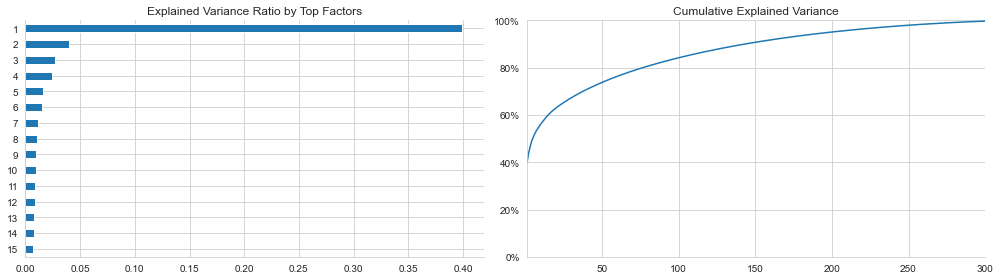

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(pca.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:15].sort_values().plot.barh(title=title,
                                           ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1),
                       ax=axes[1],
                       title='Cumulative Explained Variance',
                       xlim=(1, 300))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.tight_layout()

In [12]:
risk_factors = pd.DataFrame(pca.transform(returns)[:, :2], 
                            columns=['Principal Component 1', 'Principal Component 2'], 
                            index=returns.index)
risk_factors.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2071 entries, 2010-01-05 to 2018-03-27
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Principal Component 1  2071 non-null   float64
 1   Principal Component 2  2071 non-null   float64
dtypes: float64(2)
memory usage: 48.5 KB


We can select the top two principal components to verify that they are indeed uncorrelated:

In [13]:
risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 2'])

7.396594770335e-15

Moreover, we can plot the time series to highlight how each factor captures different volatility patterns.

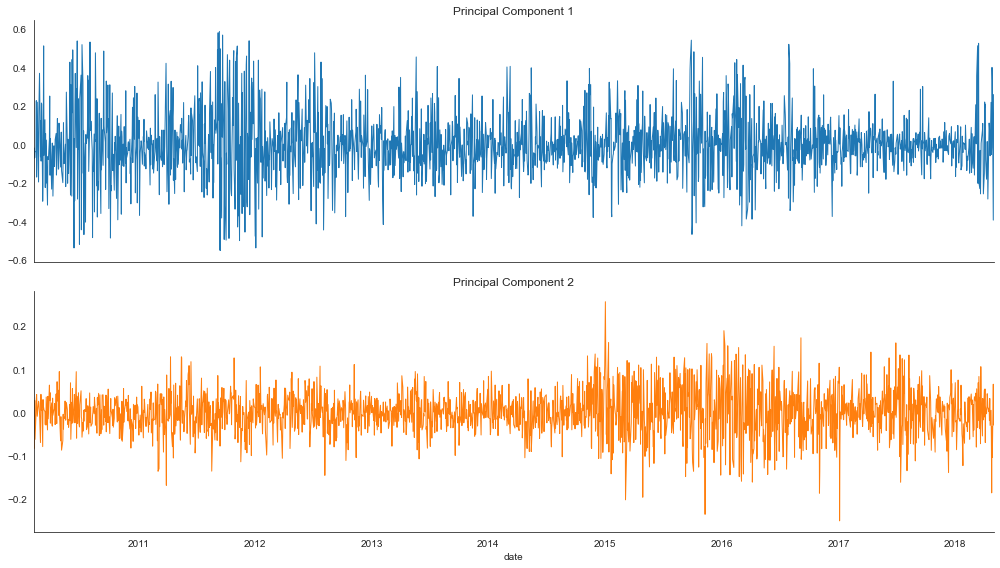

In [14]:
with sns.axes_style('white'):
    risk_factors.plot(subplots=True,
                      figsize=(14, 8),
                      title=risk_factors.columns.tolist(),
                      legend=False,
                      rot=0,
                      lw=1,
                      xlim=(risk_factors.index.min(),
                            risk_factors.index.max()))

    sns.despine()
    plt.tight_layout()

A risk factor model would employ a subset of the principal components as features to predict future returns, similar to our approach in chapter 7.

## Simulation for larger number of stocks

In [15]:
idx = pd.IndexSlice
with pd.HDFStore('../../data/assets.h5') as store:
    returns = (store['quandl/wiki/prices']
              .loc[idx['2000': '2018', :], 'adj_close']
              .unstack('ticker')
              .pct_change())

In [16]:
pca = PCA()
n_trials, n_samples = 100, 500
explained = np.empty(shape=(n_trials, n_samples))
for trial in range(n_trials):
    returns_sample = returns.sample(n=n_samples)
    returns_sample = returns_sample.dropna(thresh=int(returns_sample.shape[0] * .95), axis=1)
    returns_sample = returns_sample.dropna(thresh=int(returns_sample.shape[1] * .95))
    daily_avg = returns_sample.mean(1)
    returns_sample = returns_sample.apply(lambda x: x.fillna(daily_avg))
    pca.fit(returns_sample)
    explained[trial, :len(pca.components_)] = pca.explained_variance_ratio_

In [17]:
explained = pd.DataFrame(explained, columns=list(range(1, explained.shape[1] + 1)))
explained.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 500 entries, 1 to 500
dtypes: float64(500)
memory usage: 390.8 KB


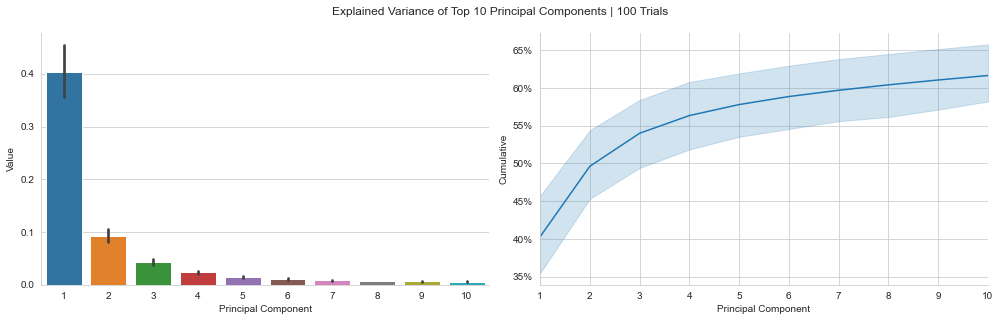

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4.5))
pc10 = explained.iloc[:, :10].stack().reset_index()
pc10.columns = ['Trial', 'Principal Component', 'Value']

pc10['Cumulative'] = pc10.groupby('Trial').Value.transform(np.cumsum)
sns.barplot(x='Principal Component', y='Value', data=pc10, ax=axes[0])
sns.lineplot(x='Principal Component', y='Cumulative', data=pc10, ax=axes[1])
axes[1].set_xlim(1, 10)
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
fig.suptitle('Explained Variance of Top 10 Principal Components | 100 Trials')
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.90)